In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.datasets import make_blobs
import random
from itertools import cycle

%matplotlib inline

   
# I. РЕАЛИЗАЦИЯ K-MEANS
Реализуем алгоритм k-means и протестируем его на различных датасетах (в первом случае взят датасет sklearn, далее искусственно будет создан более сложный датасет)

# Датасет с явно выраженными кластерами, число кластеров известно заранее
Отберём $samples = 250$ точек на плоскости и визуализируем их.

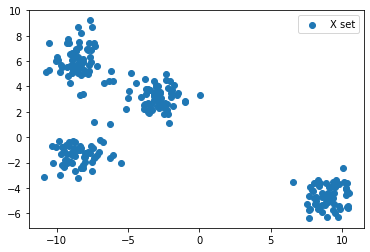

In [6]:
samples = 250

def show_2D_set(X_set):
    plt.scatter(X[:,0], X[:,1], label = 'X set')
    plt.legend(loc="upper right")
    plt.show()

X, y = make_blobs(n_samples = samples, centers = 4, shuffle = True)
show_2D_set(X)

Построим матрицу попарных расстояний между точками множества X и убедимся в том, что при их неупорядоченности матрица отображает хаос.

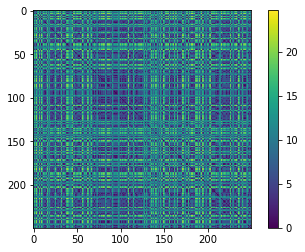

In [7]:
matrix_of_eucl_distances = np.array([[np.linalg.norm(X[i]-X[j]) for i in range(samples)] for j in range(samples)])
plt.imshow(matrix_of_eucl_distances)
plt.colorbar()
plt.show()

Далее в прямоугольнике $(x, y): (x_{min} \leq x \leq x_{max}, y_{min} \leq y \leq y_{max})$ выберем $k$ точек, где $k$ - число кластеров. Число кластеров считаем известным.

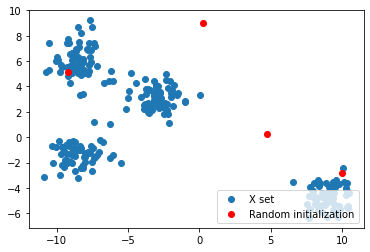

In [14]:
k = 4

def random_init(X, k, dim = 2):
    centroids = np.random.random((k, 2))
    for i in range(dim):
        centroids[:,i] = centroids[:,i] * (np.max(X[:,i]) - np.min(X[:,i])) + np.min(X[:,i])
    return centroids

centroids = random_init(X, k, dim = 2)

plt.scatter(X[:,0], X[:,1], label = 'X set')
plt.scatter(centroids[:,0], centroids[:,1], color='red', label = 'Random initialization')
plt.legend(loc="lower right")
plt.show()

Теперь создадим словарь, в котором ключами являются номера кластеров, а значениями для каждого ключа - списки точек множества $X$. При создании словаря необходимо обновлять списки, добавляя к ним новые элементы. Чтобы избежать добавления элемента к спискам всех ключей, а также некоторых возможных ошибок, воспользуемся типом defaultdict.

In [15]:
def clusters_dictionary(X, centroids, k):
    d = defaultdict(list)
    for elem in X:
        d[np.argmin(np.linalg.norm(centroids-np.tile(elem, (k, 1)), axis=1))].append(elem)
    return d

clusterized = clusters_dictionary(X, centroids, k)

Для визуализации предполагаем, что наш датасет не предполагает наличия более 10 кластеров (в противном случае цвета начнут повторяться).
На изображении ниже присутствуют все $k$ цветов. Это означает, что для любой точки $p$ из числа уже случайно выбранных из прямоугольника точек найдется точка множества $X$, для которой эта $p$ - ближайшая. В общем случае этого может не произойти, поэтому в дальнейшем будем учитывать случаи деления на 0 и случаи пустых векторов/матриц.

CLUSTERS FOUND: 4


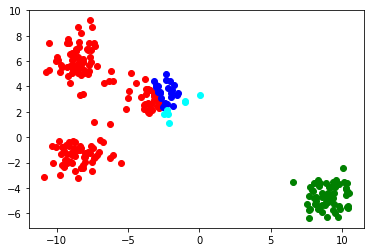

In [16]:
def show_2D_clusters(clusterized, print_info = False, legend = True, show = True):
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'pink', 'lawngreen', 'maroon', 'slategray']
    n_clusters = 0
    for c, points in zip(cycle(colors), clusterized.values()):
        n_clusters+=1
        x_axis = [p[0] for p in points]
        y_axis = [p[1] for p in points]
        plt.scatter(x_axis, y_axis, color=c)
    if print_info:
        print('CLUSTERS FOUND:', n_clusters)
        if n_clusters>len(colors):
            print('WARNING! NOT ENOUGH COLORS. SOME CLUSTERS ARE IN THE SAME COLOR')
    if legend:
        plt.legend(loc="upper right")
    if show:
        plt.show()

show_2D_clusters(clusterized, print_info  = True, legend = False)

Теперь будем изменять центроиды, свигая их в "центры масс" точек, ближайших к этому центроиду. При пересчёте координат центроида мы также можем побочно получать расстояние между старой и новой точкой. Когда сумма сдвигов центроидов станет равна 0, кластеры стабилизируются, это означает конец работы алгоритма. <br><br> Алгоритм k-means (замечание: этот и последующие алгоритмы реализован для произвольной размерности, что будет использовано в примерах задач): <br>0. Инициализация центроидов<br> 1.Каждый алгоритм приписать к тому кластеру, к центру которого он ближе: $$C_t = \{i|k = \underset{t}{argmin} \left\| x_i - \mu_t \right\|\}$$ <br>2. Пересчитать центры кластеров: $$\mu_t = \frac{1}{|C_t|}\sum\limits_{i \in C_t}x_i$$ <br>В случае неопределённости вида $\frac{0}{0}$ центры оставлять неизменными. <br><br>3. Повторять 1-2 пока кластеры не стабилизируются.

In [17]:
def k_means(X, k, centroids, dim = 2, print_iterations = False):
    #Пересчет центра кластеров
    #return new_center, delta_r
    def new_center(list_of_points, old, dim):
        if len(list_of_points) == 0:
            return old, 0.0
        else:
            new = 1/len(list_of_points) * np.array([np.sum(np.array(list_of_points)[:,i]) for i in range(dim)])
            return new, np.sqrt(np.sum((new-old)**2))

    old_centroids = centroids.copy()
    clusterized = clusters_dictionary(X, centroids, k)
    iterations = 0
    deltas = np.array([1.0, 1.0, 1.0])

    while np.sum(deltas)>0:
        iterations+=1
        new_centroids, deltas = [], np.array([])

        for i in range(k):
            new_centroid, delta_r = new_center(clusterized[i], old_centroids[i], dim)
            new_centroids.append(new_centroid)
            deltas = np.append(deltas, delta_r)

        new_centroids = np.array(new_centroids)
        clusterized = clusters_dictionary(X, new_centroids, k)
        old_centroids = new_centroids.copy()
    clusterized = {k:v for k,v in clusterized.items() if v}
    if print_iterations:
        print('ITERATIONS:', iterations)
    return clusterized

In [18]:
clusterized = k_means(X, k, centroids, dim = 2, print_iterations = True)

ITERATIONS: 11


Визуализируем результат работы алгоритма.

CLUSTERS FOUND: 4


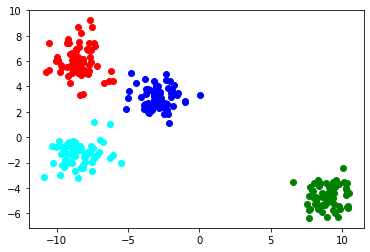

In [19]:
show_2D_clusters(clusterized, print_info = True, legend = False)

Переставим столбцы и строки матрицы попарных расстояний таким образом, чтобы они шли друг за другом получившимися кластерами. На главной диагонали стоят $k$ тёмных блоков - это и есть кластеры, расстояние между точками в них мало. 

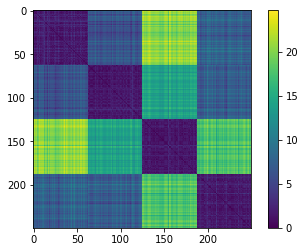

In [20]:
X = []
for i in range(len(clusterized)):
    X += clusterized[i]
matrix_of_eucl_distances = np.array([[np.linalg.norm(X[i]-X[j]) for i in range(samples)] for j in range(samples)])
plt.imshow(matrix_of_eucl_distances)
plt.colorbar()
plt.show()

# Усложним задачу для кластеризатора

Зададим не шарообразное облако точек, а более разреженную структуру. Добавим больше отдельно стоящих точек, чтобы исследовать, как кластеризатор поведёт себя в случае сдвига центров масс в сторону этих далеко стоящих точек. В этот раз возьмём $k=10$. Эксперименты на прошлом датасете показали, что в случае явно избыточного $k$, но достаточно "хороших" данных все лишние центры теряют значимость при работе алгоритма, то есть получается менее $k$ кластеров.

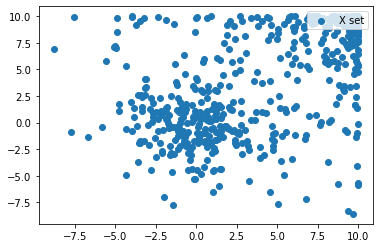

In [617]:
k = 10

#Использование некоторых функций для распределения по области
X = np.concatenate((np.random.randn(samples, 2)*2.5, np.cos(np.random.randn(samples, 2))*10.0))

show_2D_set(X)

Вновь возьмём случайные точки из прямоугольника $(x, y): (x_{min} \leq x \leq x_{max}, y_{min} \leq y \leq y_{max})$ и разобьём множество $X$ по тому же принципу. Как видно из изображения, в этот раз одна из случайных точек оказалась такой, что все точки из множества $X$ ближе к каким-то другим центроидам.

CLUSTERS FOUND: 9


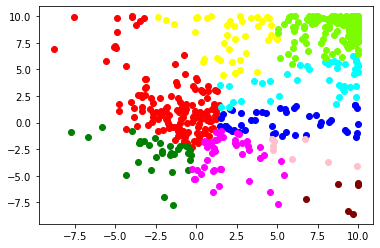

In [619]:
centroids = np.random.random((k, 2))
centroids[:,0] = centroids[:,0] * (np.max(X[:,0]) - np.min(X[:,0])) + np.min(X[:,0])
centroids[:,1] = centroids[:,1] * (np.max(X[:,1]) - np.min(X[:,1])) + np.min(X[:,1])

clusterized = clusters_dictionary(X, centroids, k)

show_2D_clusters(clusterized, print_info = True, legend = False)

Снова используем алгоритм кластеризации.

In [620]:
%%time
clusterized = k_means(X, k, centroids, dim = 2, print_iterations = True)

ITERATIONS: 18
Wall time: 165 ms


Получаем следующий результат.

CLUSTERS FOUND: 10


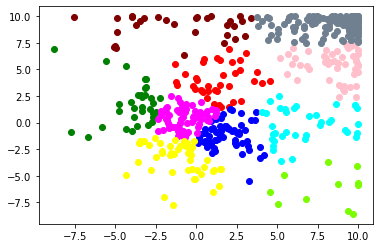

In [621]:
show_2D_clusters(clusterized, print_info = True, legend = False)

Как мы видим, результат получился крайне спорным, о чём свидетельствует и матрица попарных расстояний (блоки кластеров, которых должно быть 10, очень плохо выражены, что происходит по большей части из-за точек из окрестности начала координат). Гораздо логичнее было бы разбить точки на меньшее число кластеров. <br>Таким образом, выбор числа $k$ очень важен.<br>  

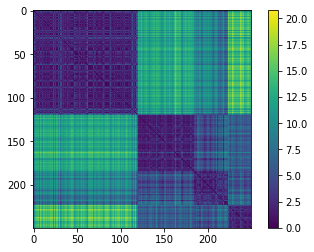

In [622]:
X = []
for i in range(k):
    X += clusterized[i]
matrix_of_eucl_distances = np.array([[np.linalg.norm(X[i]-X[j]) for i in range(samples)] for j in range(samples)])
plt.imshow(matrix_of_eucl_distances)
plt.colorbar()
plt.show()

Теперь запустим алгоритм несколько раз для разного количества точек и исследуем зависимость времени сходимости от числа точек.

In [21]:
from time import time

time_array = []

for n_samples in range(1, 15002, 1000):
    start_timer = time()
    
    X = np.concatenate((np.random.randn(n_samples, 2)*2.5, np.cos(np.random.randn(n_samples, 2))*10.0))
    
    centroids = np.random.random((k, 2))
    centroids[:,0] = centroids[:,0] * (np.max(X[:,0]) - np.min(X[:,0])) + np.min(X[:,0])
    centroids[:,1] = centroids[:,1] * (np.max(X[:,1]) - np.min(X[:,1])) + np.min(X[:,1])


    clusterized = k_means(X, k, centroids, dim = 2)

    end_timer = time()-start_timer
    time_array.append(end_timer)

В ходе эксперимента иногда происходило так, что число точек возрастало, но время работы алгоритма значительно уменьшалось. Объясняется это сокращением числа итераций из-за удачной случайной инициализации. Таким образом, начальная инициализация центроидов также очень важна.

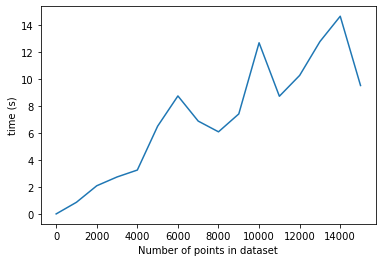

In [22]:
plt.plot([i for i in range(1, 15002, 1000)], time_array)
plt.xlabel('Number of points in dataset')
plt.ylabel('time (s)')
plt.show()

# II. О СТРАТЕГИЯХ НАЧАЛЬНОЙ ИНИЦИАЛИЗАЦИИ ЦЕНТРОИДОВ
Итак, случайная инициализация не всегда приводит к желаемому результату, к тому же это не оптимально по времени.
Поэтому рассмотрим другие стратегии выбора начальной инициализации центроидов.

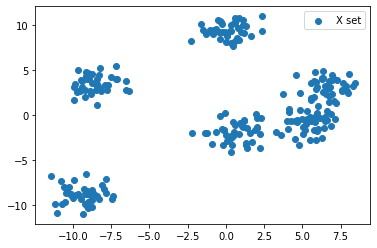

In [634]:
k = 6
X, y = make_blobs(n_samples = samples, centers = k, shuffle = True)
show_2D_set(X)

# РАВНОМЕРНАЯ ИНИЦИАЛИАЛИЗАЦИЯ

Точки расположены вдоль одной из осей ($OX$) на равном расстоянии друг от друга. Такая инициализация может быть хороша, если точки распределены равномерно относительно полуплоскостей, на которые разделяет плоскость ось $OX$. Однако, если же это не так, часть центроидов выбывает при применении алгоритма $k means$, что крайне нежелательно, если мы уверены в хорошо подобранном числе $k$.

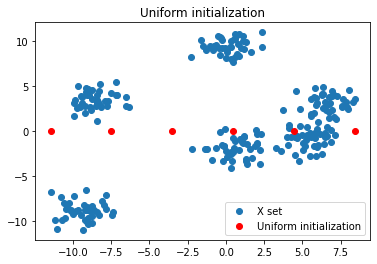

In [645]:
def uniform_init(X, k, dim = 2):
    centroids = np.concatenate((np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=k).reshape(k, 1), np.zeros((k, dim-1))), axis = 1)
    return centroids

centroids = uniform_init(X, k, dim=2)

plt.scatter(X[:,0], X[:,1], label = 'X set')
plt.scatter(centroids[:,0], centroids[:,1], color='red', label = 'Uniform initialization')
plt.title('Uniform initialization')
plt.legend(loc="lower right")
plt.show()

# РАДИАЛЬНАЯ (ЦЕНТРАЛЬНАЯ) ИНИЦИАЛИЗАЦИЯ
Найдём "центр масс" датасета. Далее от этого центра в случайных направлениях будем откладывать отрезки длины 1. Концы этих отрезков и будем считать центроидами.

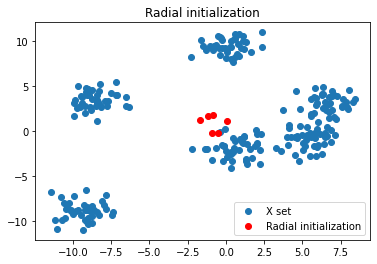

In [644]:
def radial_init(X, k):
    center = np.mean(X, axis = 0)
    centroids = np.array([0.0, 0.0])
    for i in range(k):
        phi = random.random()*2*3.14
        centroids = np.vstack([centroids, center+np.array([np.sin(phi), np.cos(phi)])])
    return centroids[1:]

centroids = radial_init(X, k)

plt.scatter(X[:,0], X[:,1], label = 'X set')
plt.scatter(centroids[:,0], centroids[:,1], color='red', label = 'Radial initialization')
plt.title('Radial initialization')
plt.legend(loc="lower right")
plt.show()

# k-MEANS++
Первый центроид выберем случайно из точек датасета. Следующие $k-1$ центроидов выбираем так, чтобы каждый из них был наиболее удалён от уже найденных центроидов.

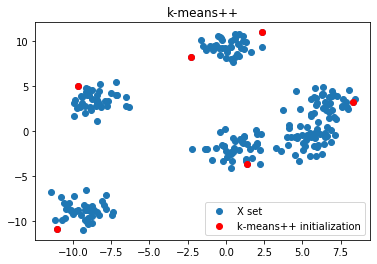

In [639]:
def k_means_plusplus_init(X, k, dim = 2):
    centroids = []
    centroids.append(X[np.random.randint(len(X))])

    for i in range(k - 1):
        distlist = []
        for point in X:
            #4 с запасом, можно 2
            min_d = 4 * np.max(np.linalg.norm(X, axis = 1))
            for centroid in centroids:
                min_d = min(min_d, np.linalg.norm(centroid - point))
            distlist.append(min_d)
             
        distlist = np.array(distlist)
        next_centroid = X[np.argmax(distlist)]
        centroids.append(next_centroid)
    return np.array(centroids)

centroids = k_means_plusplus_init(X, k)

plt.scatter(X[:,0], X[:,1], label = 'X set')
plt.scatter(centroids[:,0], centroids[:,1], color='red', label = 'k-means++ initialization')
plt.title('k-means++')
plt.legend(loc="lower right")
plt.show()

# СРАВНЕНИЕ СТРАТЕГИЙ ИНИЦИАЛИЗАЦИИ

# 1. СРАВНЕНИЕ ВРЕМЕНИ СХОДИМОСТИ

Сначала оценим время сходимости основного алгоритма $k-means$ после каждой из инициализаций.

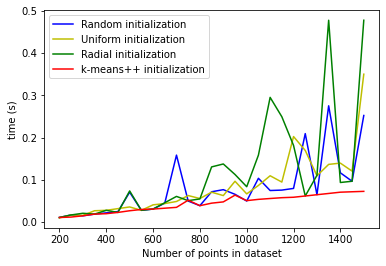

In [205]:
from time import time
random_time, uniform_time, radial_time, k_means_plusplus_time = [], [], [], []
for n_samples in range(200, 1501, 50):
    k = n_samples//100
    X, y = make_blobs(n_samples = n_samples, centers = k, shuffle = True, center_box = (-100, 100))
    
    centroids = random_init(X, k, dim = 2)
    start_timer = time()
    clusterized = k_means(X, k, centroids, dim = 2, print_iterations = False)
    random_time.append(time() - start_timer)
    
    centroids = uniform_init(X, k, dim = 2)
    start_timer = time()
    clusterized = k_means(X, k, centroids, dim = 2, print_iterations = False)
    uniform_time.append(time() - start_timer)
    
    centroids = radial_init(X, k)
    start_timer = time()
    clusterized = k_means(X, k, centroids, dim = 2, print_iterations = False)
    radial_time.append(time() - start_timer)
    
    centroids = k_means_plusplus_init(X, k, dim = 2)
    start_timer = time()
    clusterized = k_means(X, k, centroids, dim = 2, print_iterations = False)
    k_means_plusplus_time.append(time() - start_timer)
for method, c, lbl in zip([random_time, uniform_time, radial_time, k_means_plusplus_time], ['b', 'y', 'g', 'r'], ['Random', 'Uniform', 'Radial', 'k-means++']):
    plt.plot([i for i in range(200, 1501, 50)], method, c = c, label = lbl+' initialization')
plt.xlabel('Number of points in dataset')
plt.ylabel('time (s)')
plt.legend(loc="upper left")
plt.show()

Видно, что инициализация с помощью $k-means++$ позволяет основному алгоритму сходиться быстрее даже при небольших датасетах.

# 2. СРАВНЕНИЕ КАЧЕСТВА КЛАСТЕРИЗАЦИИ С ПОМОЩЬЮ SILHOUETTE_SCORE

Реализация и описание silhouette_score будет приведено ниже, где будет описываться способ поиска числа $k$.
По полученному ниже графику можно судить о качестве кластеризации при различных начальных инициализациях центроидов.

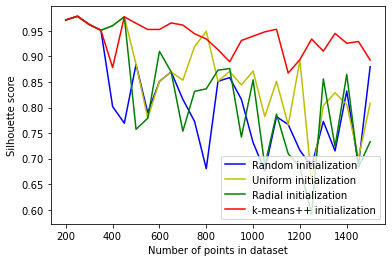

In [208]:
random_score, uniform_score, radial_score, k_means_plusplus_score = [], [], [], []
for n_samples in range(200, 1501, 50):
    k = n_samples//100
    X, y = make_blobs(n_samples = n_samples, centers = k, shuffle = True, center_box = (-100, 100))
    
    clusterized = k_means(X, k, random_init(X, k, dim = 2), dim = 2, print_iterations = False)
    random_score.append(silhouette_score(clusterized, n_samples))
    
    clusterized = k_means(X, k, uniform_init(X, k, dim = 2), dim = 2, print_iterations = False)
    uniform_score.append(silhouette_score(clusterized, n_samples))
    
    clusterized = k_means(X, k, radial_init(X, k), dim = 2, print_iterations = False)
    radial_score.append(silhouette_score(clusterized, n_samples))
    
    clusterized = k_means(X, k, k_means_plusplus_init(X, k, dim = 2), dim = 2, print_iterations = False)
    k_means_plusplus_score.append(silhouette_score(clusterized, n_samples))

for method, c, lbl in zip([random_score, uniform_score, radial_score, k_means_plusplus_score], ['b', 'y', 'g', 'r'], ['Random', 'Uniform', 'Radial', 'k-means++']):
    plt.plot([i for i in range(200, 1501, 50)], method, c = c, label = lbl+' initialization')
plt.xlabel('Number of points in dataset')
plt.ylabel('Silhouette score')
plt.legend(loc="lower right")
plt.show()

Видно, что при инициализации с помощью $k-means++$ кластеризация получается более качественной и надёжной.

# 3. ВИЗУАЛИЗИРОВАННЫЙ ПРИМЕР

Пример кластеризации трёх различных множеств точек. Как видно из изображений, с усложнением датасета появляются проблемы, если инициализация не очень точная. Однако при использовании точного $k-means++$ получается кластеризовать и более сложные данные. 

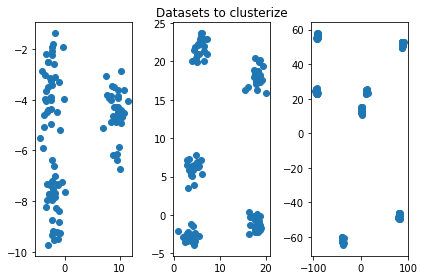

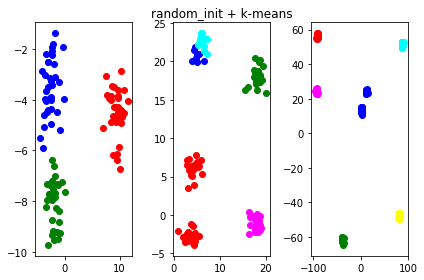

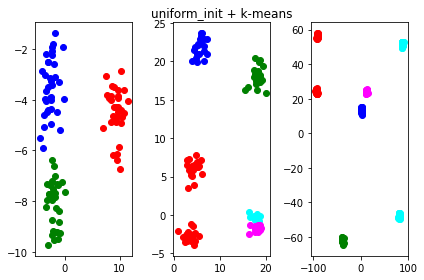

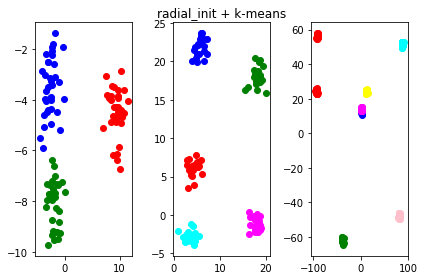

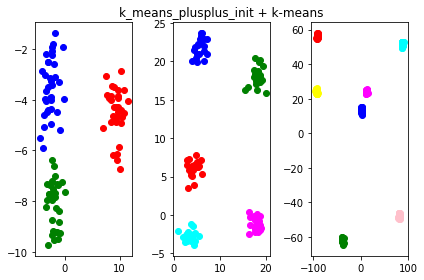

In [213]:
X1, y = make_blobs(n_samples = 100, centers = 3)
X2, y = make_blobs(n_samples = 100, centers = 5, center_box = (-25.0, 25.0))
X3, y = make_blobs(n_samples = 250, centers = 7, center_box = (-100.0, 100.0))

for i, X_set in zip([1, 2, 3], [X1, X2, X3]):
    plt.subplot(1, 3, i)
    plt.scatter(X_set[:,0], X_set[:,1])
    if i==2:
        plt.title('Datasets to clusterize')
plt.tight_layout()
plt.show()

for method in [random_init, uniform_init, radial_init, k_means_plusplus_init]:
    i = 1
    for X_set in [X1, X2, X3]:
        plt.subplot(1, 3, i)
        clusterized = k_means(X_set, 2*i+1, method(X_set, 2*i+1), dim = 2, print_iterations = False)
        show_2D_clusters(clusterized, print_info  = False, legend = False, show = False)
        if i == 2:
            plt.title(method.__name__ + ' + k-means')
        i+=1
    plt.tight_layout()
    plt.show()

# III. О стратегии выбора k (silhouette method)
Пусть мы нашли идеальную кластеризацию для нашего датасета. Это означает, что среднее внутрикластеровое расстояние (назовём его $a$) минимально, а среднее межкластеровое расстояние (назовём его $b$) максимально. Таким образом, задача сводится к максимизации разности $b-a$. Введём величину для оценки качества кластеризации, нормировав эту разность: $$\zeta = \frac{\sum\limits_{i=1}^n\frac{b_i-a_i}{max(a_i, b_i)}}{n}$$ где $a_i$ - среднее расстояние от данной точки до точек своего кластера, $b_i$ - среднее расстояние от данной точки до точек ближайшего чужого кластера, $n$ - мощность множества $X$.<br>Реализуем алгоритм подбора числа $k$:

In [705]:
def count_a(point, cluster):
    return np.mean(np.linalg.norm(np.array(cluster) - point, axis = 1))

def count_b(point, nearest_cluster):
    return np.mean(np.linalg.norm(np.array(nearest_cluster) - point, axis = 1))

def get_nearest_cluster_key(key, clusterized):
    centroids = np.array([np.mean(clusterized[i], axis=0) for i in clusterized.keys()])
    deltas = np.linalg.norm(centroids - np.mean(clusterized[key], axis = 0), axis = 1)
    return tuple(clusterized.keys())[np.where(deltas == np.min(deltas[np.nonzero(deltas)]))[0][0]]

def silhouette_score(clusterized, samples):
    score = 0
    for i in clusterized.keys():
        for point in clusterized[i]:
            a = count_a(point, clusterized[i])
            b = count_b(point, clusterized[get_nearest_cluster_key(i, clusterized)])
            score += (b-a)/max(a, b)
    return score / samples

Предполагается, что мы можем оценить сверху число кластеров. В худшем случае можно оценить и количеством точек, но работа алгоритма будет очень долгой.

In [706]:
def silhouette_method(X, dim = 2, max_k = 15, init_method = k_means_plusplus_init, print_table = False):
    table_of_scores = {2: 0}
    for test_k in range(2, max_k+1):
        counter = 0
        centroids = init_method(X, test_k, dim = dim)
        clusterized = k_means(X, test_k, centroids, dim = dim)
        if test_k not in table_of_scores:
            table_of_scores[test_k] = 0
        table_of_scores[test_k]+=silhouette_score(clusterized, samples)
    if print_table:
        print(table_of_scores.items())
    return(2+np.argmax(np.array([value for value in table_of_scores.values()])))

Протестируем алгоритм на датасете с относительно большим числом кластеров (13):

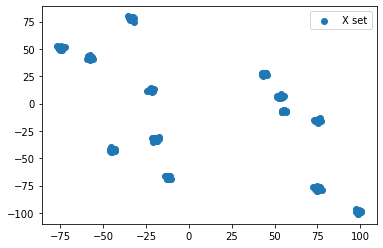

In [707]:
X, y = make_blobs(n_samples = samples, centers = 13, center_box = (-100, 100))
show_2D_set(X)

Получаем точный ответ:

In [708]:
silhouette_method(X, dim = 2, print_table = True)

dict_items([(2, 0.5113042144985939), (3, 0.5219070137564171), (4, 0.7143398736086217), (5, 0.6916095461528022), (6, 0.7530569236453438), (7, 0.7131533883799613), (8, 0.8008346865287045), (9, 0.7662679920214752), (10, 0.8128072292426988), (11, 0.8827955953311089), (12, 0.9053065741421011), (13, 0.9297591474567072), (14, 0.8850939043348083), (15, 0.8540024286769038)])


13

# IV. О НЕКОТОРЫХ ЗАДАЧАХ, В КОТОРЫХ ПРИМЕНИМА КЛАСТЕРИЗАЦИЯ
Как было показано до этого, успех кластеризации сильно зависит от качества предоставляемых данных. Если встречается практическая задача, такая, что можно ввести адекватную метрику на прецедентах, и при этом классы достаточно сильно отличаются друг от друга, можно попробовать применять кластеризацию. Примерами таких задачи могут являться задачи классификации, задачи выявления аномалий, выделения границ и т.д.
Рассмотрим пару задач, в которых может быть применена кластеризация.

# 1. Выделение границ объектов на изображении
Возьмём некоторое простое изображение, содержащее несколько оттенков одних и тех же цветов и для простоты переведём его в чёрно-белый формат:

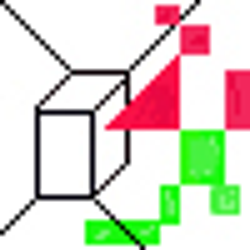

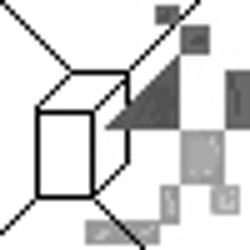

In [519]:
from IPython.display import Image
from PIL import Image as PIL_Image

img = PIL_Image.open('./Data/geometry.jpg').convert('L')
display(PIL_Image.open('./Data/geometry.jpg').resize((250, 250)))
display(img.resize((250, 250)))

Удалим из датасета фон и спроецируем изображение на плоскость, ортогональную оси яркости в формате grayscale.

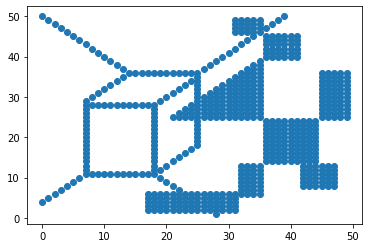

In [652]:
X = []
level = 230
for i in range(np.array(img).shape[0]):
    for j in range(np.array(img).shape[1]):
        if np.array(img)[i][j]<level:
            X.append([np.array(img).shape[0] - float(i), float(j), float(np.array(img)[i][j])])
X = np.array(X)

plt.scatter(X[:,1], X[:,0])
plt.show()

In [653]:
def show_3D_set(X):
    ax.scatter(X[:,0], X[:,1], X[:,2])
    plt.show()

def show_3D_clusters(clusterized, print_info = False):
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'pink', 'lawngreen', 'maroon', 'slategray']
    n_clusters = 0
    for c, points in zip(cycle(colors), clusterized.values()):
        n_clusters+=1
        x_axis = [p[0] for p in points]
        y_axis = [p[1] for p in points]
        z_axis = [p[2] for p in points]
        ax.scatter(x_axis, y_axis, z_axis, color=c)
    if print_info:
        print('CLUSTERS FOUND:', n_clusters)
        if n_clusters>len(colors):
            print('WARNING! NOT ENOUGH COLORS. SOME CLUSTERS ARE IN THE SAME COLOR')
    plt.show()

В действительности датасет выглядит так:

<IPython.core.display.Javascript object>


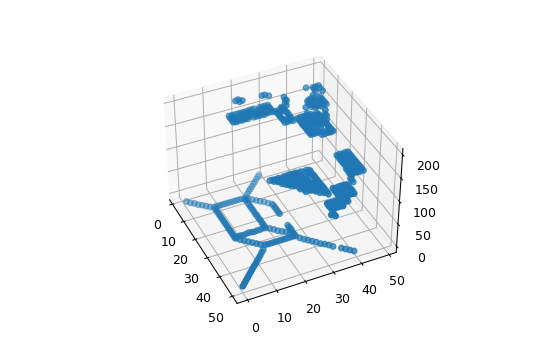

In [654]:
from mpl_toolkits import mplot3d
%matplotlib notebook

ax = plt.axes(projection = '3d')

show_3D_set(X)

Выделим схожие по яркости объекты из рисунка с помощью кластеризации, в результате чего получим весьма точное выделение отдельных объектов. Далее остаётся только спроецировать их на плоскость и продолжить работу с ними по отдельности, если это требуется.

In [656]:
#Ищем число k
silhouette_method(X, dim = 3, print_table = False)

3

In [657]:
clusterized = k_means(X, 3, k_means_plusplus_init(X, 3, dim = 3), dim = 3, print_iterations = False)

<IPython.core.display.Javascript object>


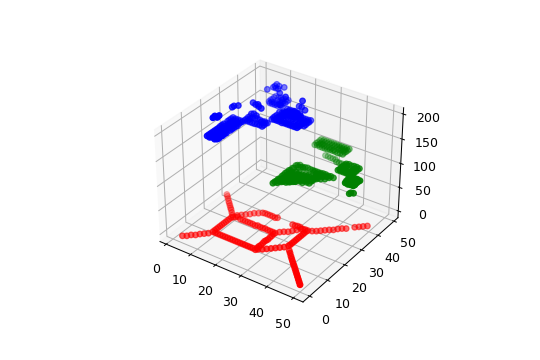

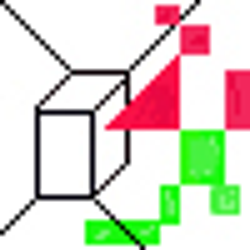

In [658]:
from mpl_toolkits import mplot3d
%matplotlib notebook

ax = plt.axes(projection = '3d')

def show_3D_clusters(clusterized, print_info = False):
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'pink', 'lawngreen', 'maroon', 'slategray']
    n_clusters = 0
    for c, points in zip(cycle(colors), clusterized.values()):
        n_clusters+=1
        x_axis = [p[0] for p in points]
        y_axis = [p[1] for p in points]
        z_axis = [p[2] for p in points]
        ax.scatter(x_axis, y_axis, z_axis, color=c)
    if print_info:
        print('CLUSTERS FOUND:', n_clusters)
        if n_clusters>len(colors):
            print('WARNING! NOT ENOUGH COLORS. SOME CLUSTERS ARE IN THE SAME COLOR')
    plt.show()
display(PIL_Image.open('./Data/geometry.jpg').resize((250, 250)))
show_3D_clusters(clusterized, print_info = False)

# 2. Социальная задача
Пусть для простоты существует три направления музыки: классическая, рок-, и поп-музыка. Если мы можем собрать данные о том, какие композиции отмечались как нравящиеся разными пользователями, то мы сможем выделить группы людей по музыкальным вкусам, что может быть использовано, например, для лучших музыкальных рекомендаций. Реализуем это. Каждый человек представлен точкой $(x_1, x_2, x_3)$, где $x_1, x_2 и x_3$ означают количество понравившихся композиций каждого из трёх жанров.

<IPython.core.display.Javascript object>


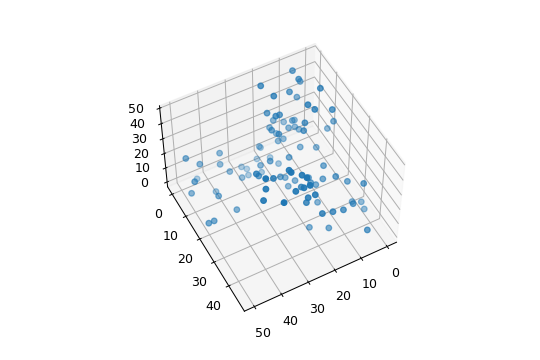

In [709]:
X = np.array([[11,  5, 42],[14, 29,  5],[39, 19,  4],[19, 12, 30],[26, 32, 40],[ 7,  0, 46],[20, 18, 10],[18, 21, 11],[30, 18, 19],[16,  3, 24],[20, 37, 28],[48,  1, 19],[21, 30, 23],[10, 15, 47],[ 9,  8, 20],[24,  9,  3],[12,  3, 20],[ 0, 15, 29],[43, 14,  9],[18,  7, 47],[19,  6,  5],[44,  0,  0],[24, 15, 20],[26, 12, 14],[17,  8, 18],[32, 38, 34],[16,  5, 18],[ 8, 30, 20],[ 9, 24, 19],[20,  2, 48],[18, 17, 21],[ 7, 16, 18],[19, 40, 19],[37,  4, 11],[18, 10,  6],[22, 35, 38],[50, 20,  5],[ 4, 31, 15],[ 3, 11, 47],[13,  8, 24],[20,  9, 29],[44,  3, 15],[11, 40, 15],[ 3, 33,  3],[ 1, 36, 19],[20,  6, 36],[ 6, 47,  8],[15, 26, 15],[34, 30, 32],[12, 14, 19],[18,  4, 22],[23,  4,  4],[10,  7, 21],[ 4,  0, 37],[34, 30, 39],[25, 29, 36],[20, 34,  0],[23, 35, 32],[ 0, 34,  2],[19, 10, 39],[15, 38,  2],[14, 23, 13],[ 2, 17, 41],[41,  8,  1],[12, 16, 33],[27,  4,  0],[20, 20,  7],[22, 36, 26],[26, 35, 32],[28,  7,  1],[35,  7,  9],[32, 10,  7],[48, 20,  5],[11,  7, 26],[29,  4,  3],[36,  2, 15],[22, 35, 21],[23, 20, 16],[33, 22, 29],[ 1, 13, 22],[17,  9, 37],[11, 27, 16],[29, 26, 29],[ 8, 16, 44],[15,  8, 18],[ 0, 36,  0],[22,  4, 12],[ 9,  5, 22],[13, 26, 12],[ 7,  4, 46],[11, 15, 36],[49,  9, 16],[21,  3,  9],[22, 37, 36],[ 6, 38, 12],[ 7,  3, 33],[15, 40, 17],[50,  8,  7],[22, 32, 35],[36, 32, 29]])

%matplotlib notebook

ax = plt.axes(projection = '3d')

show_3D_set(X)

Алгоритм выделил 4 музыкальных вкуса из информации о слушателях.

In [713]:
silhouette_method(X, dim = 3, print_table = False)

4

In [714]:
clusterized = k_means(X, 4, k_means_plusplus_init(X, 4, dim = 3), dim = 3, print_iterations = False)

В результате кластеризации выяснилось, что кроме людей, предпочитающих лишь одно направление, есть группа людей, слушающих практически всё.

<IPython.core.display.Javascript object>


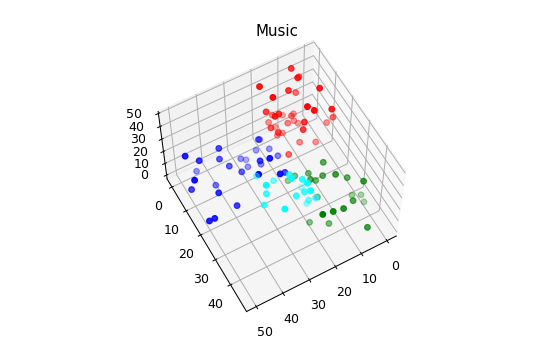

In [715]:
%matplotlib notebook
ax = plt.axes(projection = '3d')
plt.title('Music')
show_3D_clusters(clusterized, print_info = False)